In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abhishek14398/gesture-recognition-dataset
!unzip gesture-recognition-dataset.zip -d gesture_recognition_dataset

Streaming output truncated to the last 5000 lines.
  inflating: gesture_recognition_dataset/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00029.png  
  inflating: gesture_recognition_dataset/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00031.png  
  inflating: gesture_recognition_dataset/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00033.png  
  inflating: gesture_recognition_dataset/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00035.png  
  inflating: gesture_recognition_dataset/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00037.png  
  inflating: gesture_recognition_dataset/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00039.png  
  inflating: gesture_recognition_dataset/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00041.png  
  inflating: gesture_recognition_dataset/train/WIN_20180926_

In [2]:
!pip install tensorflow
!pip install keras

In [3]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import Xception, DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [4]:
# Paths for dataset
dataset_path = "gesture_recognition_dataset"  # Update with your dataset path
img_size = (224, 224)  # Image dimensions
batch_size = 32

# Image Data Generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize images
    validation_split=0.2,  # Split for validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 18312 images belonging to 2 classes.
Found 4578 images belonging to 2 classes.


In [5]:
#RESNET
def build_resnet_from_scratch(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [6]:
def build_xception_model(input_shape, num_classes):
    # Load Xception with pre-trained weights, exclude the top layer
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers (feature extraction part)
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)  # Pooling to reduce dimensions
    x = Dense(512, activation='relu')(x)            # Fully connected layer
    x = Dropout(0.5)(x)                             # Dropout for regularization
    output = Dense(num_classes, activation='softmax')(x)  # Final classification layer

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [7]:
def build_densenet_model(input_shape, num_classes):
    # Load DenseNet with pre-trained weights, exclude the top layer
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers (feature extraction part)
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)  # Pooling to reduce dimensions
    x = Dense(512, activation='relu')(x)            # Fully connected layer
    x = Dropout(0.5)(x)                             # Dropout for regularization
    output = Dense(num_classes, activation='softmax')(x)  # Final classification layer

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [8]:
# Compile and Train
input_shape = (224, 224, 3)  # Ensure images are resized to this shape
num_classes = train_gen.num_classes  # Number of classes from the training generator

# Define and initialize the models
models = {
    "ResNet": build_resnet_from_scratch(input_shape, num_classes),  # Custom implementation for ResNet
    "Xception": build_xception_model(input_shape, num_classes),
    "DenseNet": build_densenet_model(input_shape, num_classes)
}

# Dictionary to store training history for each model
history = {}

# Train each model
for name, model in models.items():
    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nTraining {name} Model...")
    # Train the model and store the training history
    history[name] = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        verbose=1
    )

    # Save the model after training
    model.save(f'{name}_model.h5')  # Save the model to a .h5 file
    print(f"{name} Model saved as {name}_model.h5")


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Training ResNet Model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


573/573 ━━━━━━━━━━━━━━━━━━━━ 342s 565ms/step - accuracy: 0.8163 - loss: 4.8247 - val_accuracy: 0.8646 - val_loss: 0.5131
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 362s 553ms/step - accuracy: 0.8688 - loss: 0.4304 - val_accuracy: 0.8689 - val_loss: 0.4224
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 333s 577ms/step - accuracy: 0.8671 - loss: 0.4013 - val_accuracy: 0.8687 - val_loss: 0.3902
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 369s 553ms/step - accuracy: 0.8715 - loss: 0.3825 - val_accuracy: 0.8692 - val_loss: 0.3883
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 319s 550ms/step - accuracy: 0.8717 - loss: 0.3859 - val_accuracy: 0.8689 - val_loss: 0.3879
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 343s 586ms/step - accuracy: 0.8683 - loss: 0.3889 - val_accuracy: 0.8689 - val_loss: 0.3881
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 377s 578ms/step - accuracy: 0.8688 - loss: 0.3940 - val_accuracy: 0.8689 - val_loss: 0.3887
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 340s 588ms/step - accuracy: 0.8702 - loss: 0.39

ResNet Model saved as ResNet_model.h5

Training Xception Model...
Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 355s 585ms/step - accuracy: 0.8518 - loss: 0.4319 - val_accuracy: 0.8510 - val_loss: 0.4473
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 362s 569ms/step - accuracy: 0.8732 - loss: 0.3433 - val_accuracy: 0.8093 - val_loss: 0.5042
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 377s 562ms/step - accuracy: 0.8837 - loss: 0.3085 - val_accuracy: 0.7641 - val_loss: 0.6079
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 385s 567ms/step - accuracy: 0.8891 - loss: 0.2944 - val_accuracy: 0.8062 - val_loss: 0.5642
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 334s 578ms/step - accuracy: 0.8953 - loss: 0.2764 - val_accuracy: 0.7532 - val_loss: 0.6443
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 373s 560ms/step - accuracy: 0.8994 - loss: 0.2557 - val_accuracy: 0.7088 - val_loss: 0.7121
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 381s 562ms/step - accuracy: 0.9131 - loss: 0.2328 - val_accuracy: 0.7875 - val_loss: 0.6288
Epoch 8/10

Xception Model saved as Xception_model.h5

Training DenseNet Model...
Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 379s 608ms/step - accuracy: 0.8519 - loss: 0.4563 - val_accuracy: 0.8615 - val_loss: 0.4208
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 347s 575ms/step - accuracy: 0.8696 - loss: 0.3574 - val_accuracy: 0.8475 - val_loss: 0.4408
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 337s 584ms/step - accuracy: 0.8762 - loss: 0.3293 - val_accuracy: 0.7556 - val_loss: 0.5595
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 379s 580ms/step - accuracy: 0.8774 - loss: 0.3282 - val_accuracy: 0.7381 - val_loss: 0.5906
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 340s 589ms/step - accuracy: 0.8871 - loss: 0.3008 - val_accuracy: 0.7464 - val_loss: 0.6015
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 367s 562ms/step - accuracy: 0.8932 - loss: 0.2835 - val_accuracy: 0.7497 - val_loss: 0.5860
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 324s 562ms/step - accuracy: 0.8991 - loss: 0.2735 - val_accuracy: 0.7896 - val_loss: 0.5673
Epoch 

DenseNet Model saved as DenseNet_model.h5


In [12]:
def evaluate_model(model, data_gen, class_names):
    y_true = data_gen.classes
    y_pred = np.argmax(model.predict(data_gen), axis=-1)

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return y_true, y_pred


In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(model, data_gen, num_classes):
    y_true = label_binarize(data_gen.classes, classes=range(num_classes))
    y_score = model.predict(data_gen)

    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()


Evaluating ResNet...
144/144 ━━━━━━━━━━━━━━━━━━━━ 67s 467ms/step
Classification Report:
              precision    recall  f1-score   support

       train       0.87      1.00      0.93      3978
         val       0.00      0.00      0.00       600

    accuracy                           0.87      4578
   macro avg       0.43      0.50      0.46      4578
weighted avg       0.76      0.87      0.81      4578



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


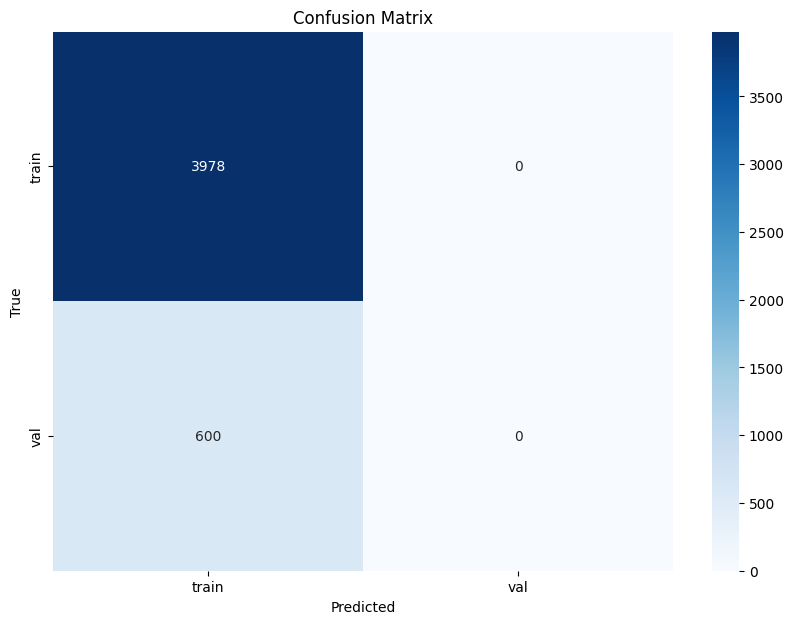

144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 471ms/step
y_true shape: (4578, 1), y_score shape: (4578, 2)


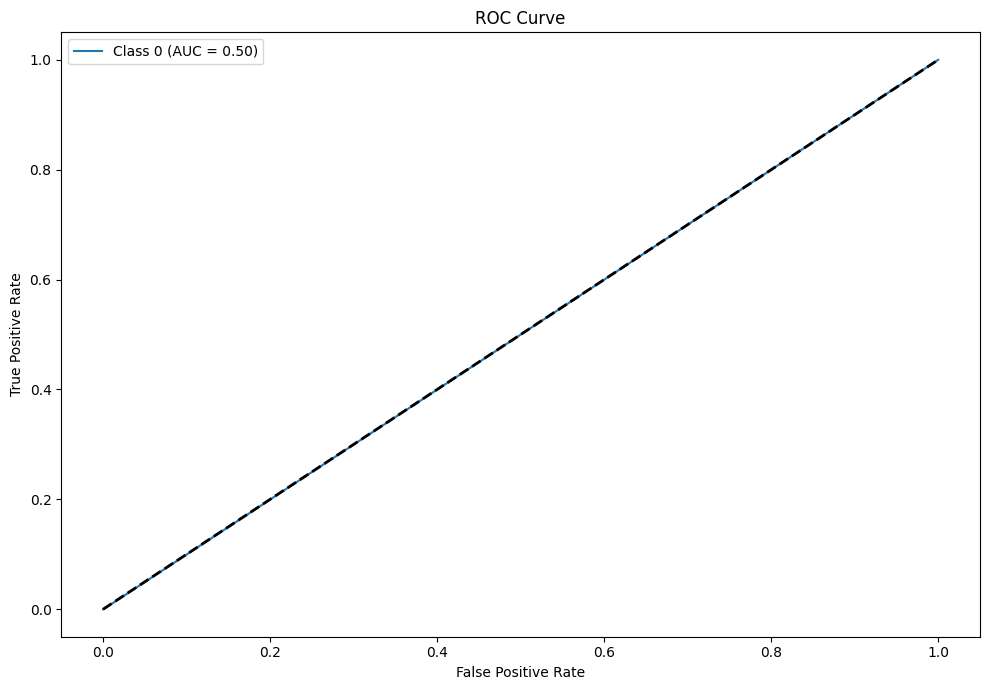

Evaluating Xception...
144/144 ━━━━━━━━━━━━━━━━━━━━ 74s 494ms/step
Classification Report:
              precision    recall  f1-score   support

       train       0.87      0.78      0.82      3978
         val       0.12      0.20      0.15       600

    accuracy                           0.70      4578
   macro avg       0.49      0.49      0.49      4578
weighted avg       0.77      0.70      0.73      4578



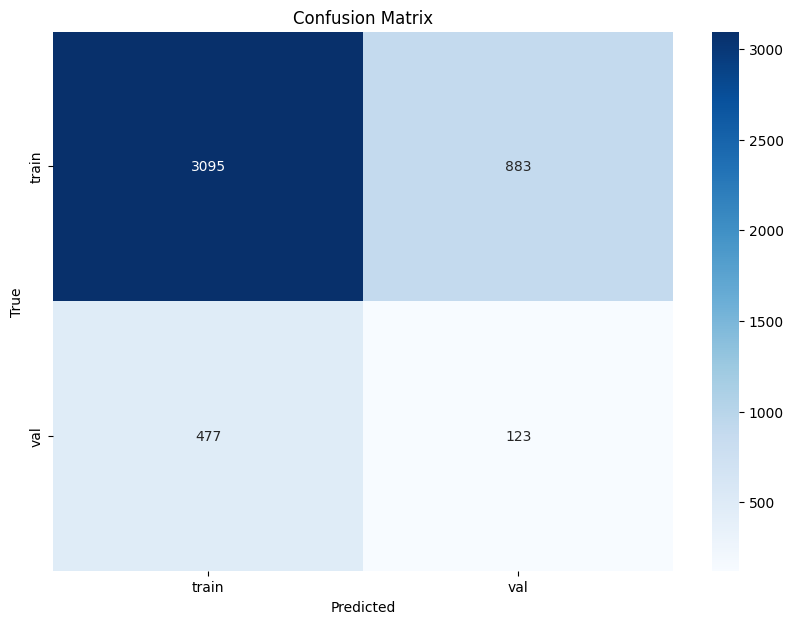

144/144 ━━━━━━━━━━━━━━━━━━━━ 69s 477ms/step
y_true shape: (4578, 1), y_score shape: (4578, 2)


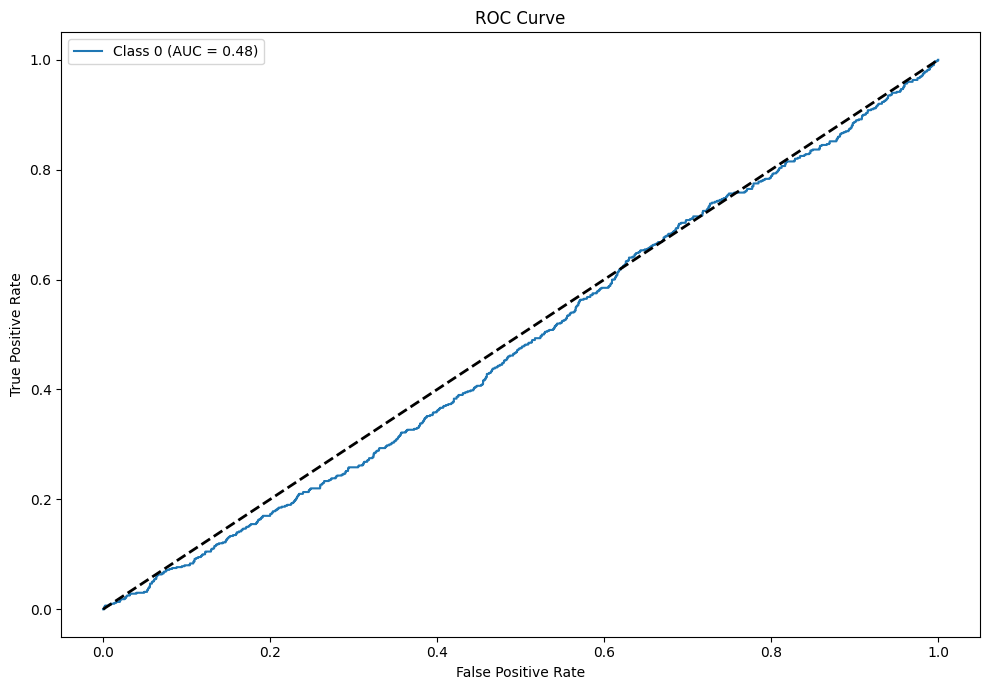

Evaluating DenseNet...
144/144 ━━━━━━━━━━━━━━━━━━━━ 89s 553ms/step
Classification Report:
              precision    recall  f1-score   support

       train       0.87      0.78      0.82      3978
         val       0.14      0.23      0.17       600

    accuracy                           0.71      4578
   macro avg       0.50      0.50      0.50      4578
weighted avg       0.77      0.71      0.74      4578



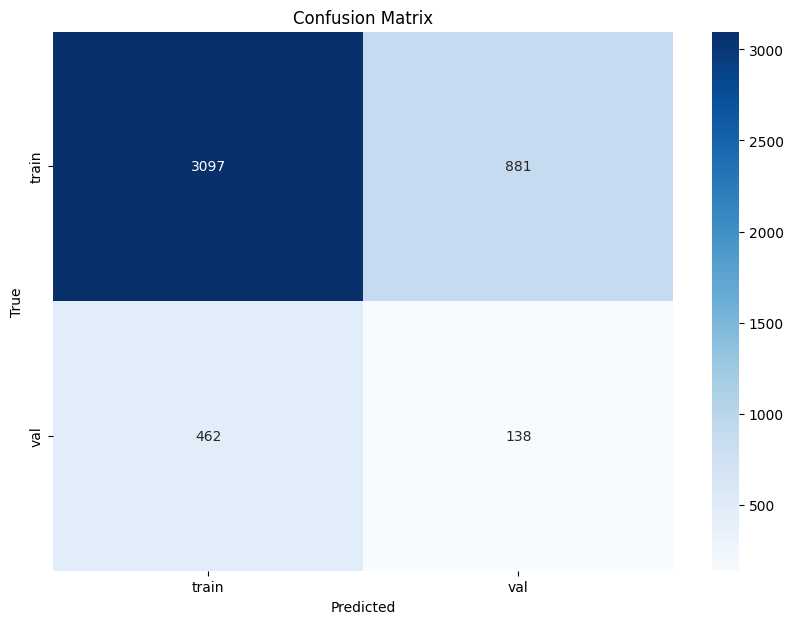

144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 486ms/step
y_true shape: (4578, 1), y_score shape: (4578, 2)


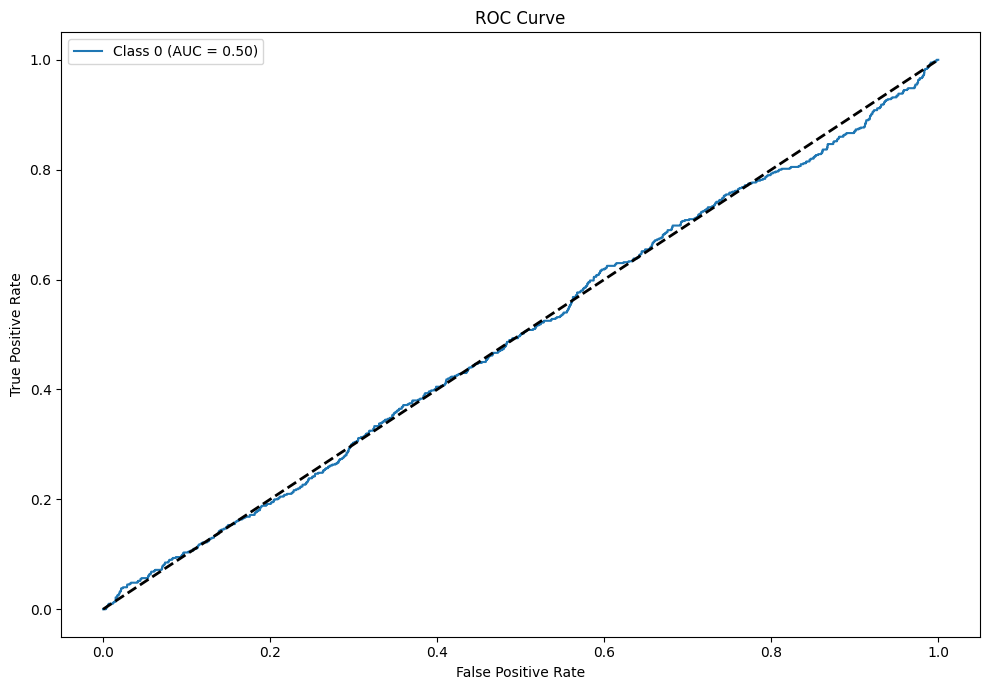

In [16]:
for name, model in models.items():
    print(f"Evaluating {name}...")
    class_names = list(train_gen.class_indices.keys())
    y_true, y_pred = evaluate_model(model, val_gen, class_names)
    plot_roc_auc(model, val_gen, num_classes)


Evaluation metrics


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [20]:
def plot_roc_auc(y_true, y_score, num_classes, model_name):
    plt.figure(figsize=(10, 7))

    # One-hot encode true labels
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    # Multi-class or binary
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:
def evaluate_model(model, data_gen, class_names, model_name):
    # Predict labels
    y_true = data_gen.classes
    y_pred_probs = model.predict(data_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Accuracy
    accuracy = np.mean(y_pred == y_true)

    # Classification Report
    print(f"Classification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, class_names, model_name)

    # ROC and AUC
    plot_roc_auc(y_true, y_pred_probs, len(class_names), model_name)

    return accuracy


Evaluating ResNet...
144/144 ━━━━━━━━━━━━━━━━━━━━ 69s 477ms/step


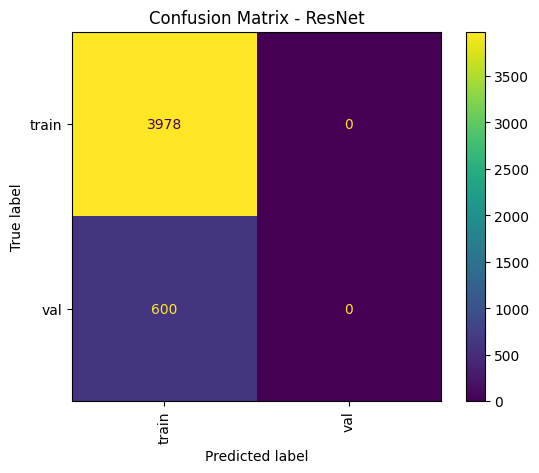

Evaluating DenseNet...
144/144 ━━━━━━━━━━━━━━━━━━━━ 80s 506ms/step


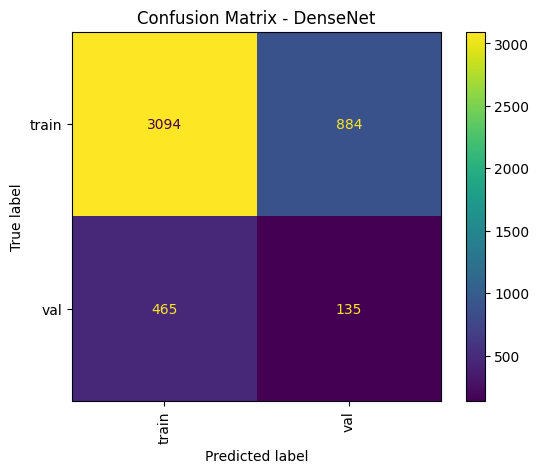

Evaluating Xception...
144/144 ━━━━━━━━━━━━━━━━━━━━ 72s 473ms/step


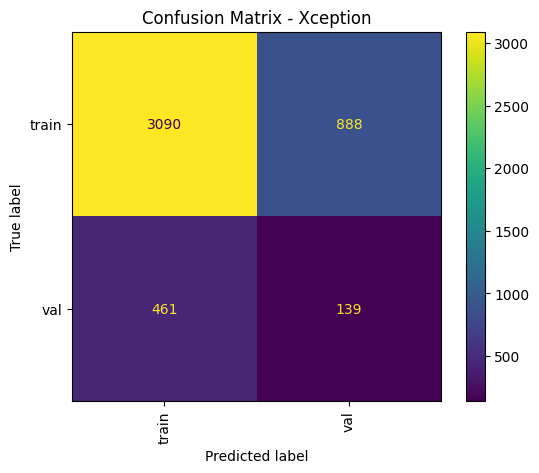

In [27]:
from tensorflow.keras.models import load_model

models = {
    "ResNet": load_model('ResNet_model.h5'),
    "DenseNet": load_model('DenseNet_model.h5'),
    "Xception": load_model('Xception_model.h5')
}

# Assuming `train_gen` and `val_gen` are your data generators
class_names = list(train_gen.class_indices.keys())

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")

    # Generate predictions
    y_pred = model.predict(val_gen)
    y_pred = y_pred.argmax(axis=1)  # Convert probabilities to class indices

    y_true = val_gen.classes  # True class labels from the validation generator

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names, name)



Evaluating ResNet...
144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 492ms/step
ResNet - Accuracy: 0.87, Precision: 0.76, Recall: 0.87, F1-Score: 0.81


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


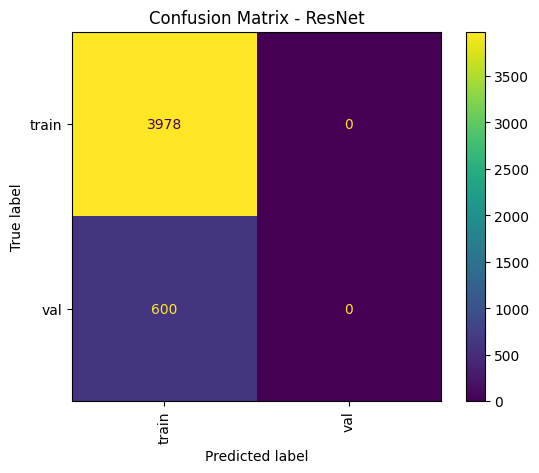

Evaluating DenseNet...
144/144 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step
DenseNet - Accuracy: 0.71, Precision: 0.77, Recall: 0.71, F1-Score: 0.74


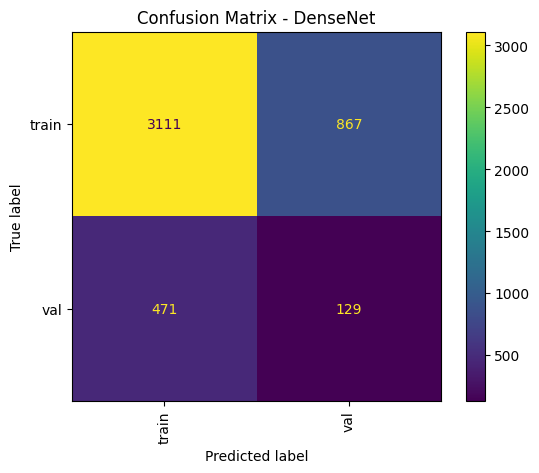

Evaluating Xception...
144/144 ━━━━━━━━━━━━━━━━━━━━ 67s 466ms/step
Xception - Accuracy: 0.72, Precision: 0.77, Recall: 0.72, F1-Score: 0.74


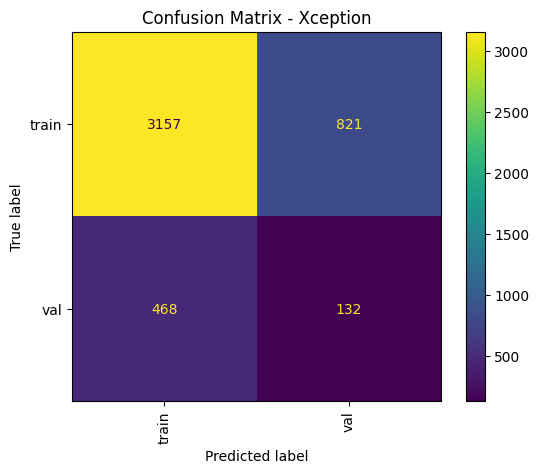

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Add these metrics inside the loop
for name, model in models.items():
    print(f"Evaluating {name}...")

    y_pred = model.predict(val_gen)
    y_pred = y_pred.argmax(axis=1)
    y_true = val_gen.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names, name)


Shape of y_true: (4578,)
Shape of y_pred_prob: (4578, 2)


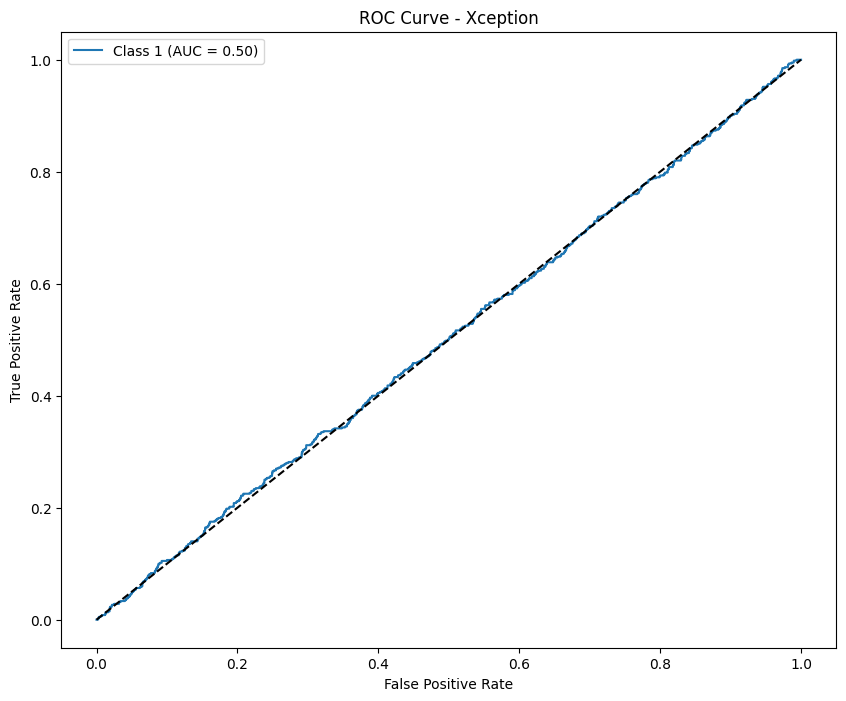

In [34]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_true is a 1D array of true class labels (0 or 1 for binary classification)
# Verify shapes to ensure they match
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_pred_prob: {y_pred_prob.shape}")

# Initialize dicts to store false positive rates, true positive rates, and AUCs
fpr, tpr, roc_auc = {}, {}, {}

# Generate ROC curve for binary classification
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])  # Use probability for the positive class (class 1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Class 1 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference (no discrimination)
plt.title(f'ROC Curve - {name}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()


In [32]:
print(y_pred_prob.shape)


(4578, 2)
